Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Using device: cuda
Loading and preprocessing data...
Performing outlier and deviation check...

OUTLIER DETECTION SUMMARY

Rows with at least one outlier: 0/5329 (0.00%)

Total outlier values detected: 0
Total values analyzed: 40992
Overall outlier percentage: 0.0000%

No outliers detected.

Columns with IQR = 0 (indicating many identical values):
  - Band gap [eV]: 944 unique values, mean=0.367324

DIRECT PERCENTILE-BASED CHECK
  Radius A [ang]:
    73 values = min(0.270000), 73 values = max(1.880000)
  Radius B [ang]:
    73 values = min(0.270000), 73 values = max(1.670000)
  Band gap [eV]:
    4132 values = min(0.000000), 1 values = max(6.221000)
  Magnetic moment [mu_B]:
    1 values = min(-0.799000), 2 values = max(2.000000)
Training stability predictor...
State size: 173, Action size: 10
Training DQN agent...


Training: 100%|██████████| 2000/2000 [03:28<00:00,  9.61it/s, AvgScore=1259.68, Eps=0.018, BestStability=-0.567]


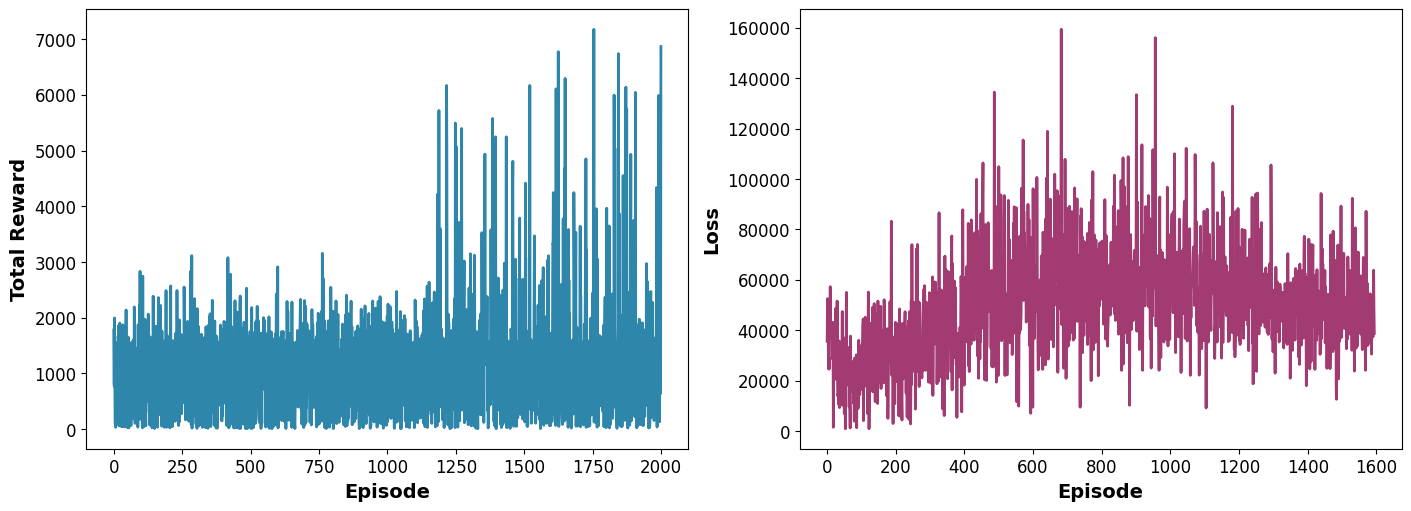

Evaluating agent...


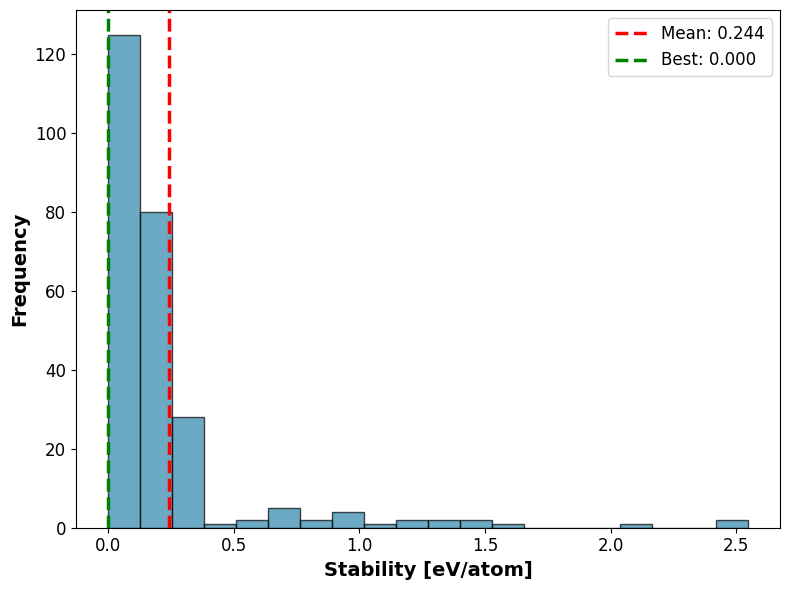


PERFORMING ERROR ANALYSIS OF DQN IN DIRECT STABILITY PREDICTION

Evaluating DQN in Direct Stability Prediction...

Error Analysis Results:
Random Forest: MAE=0.0198, RMSE=0.0344, R²=0.9966, τ=0.8245
Deep Q-Network: MAE=0.7281, RMSE=0.9302, R²=-1.4676, τ=0.0284


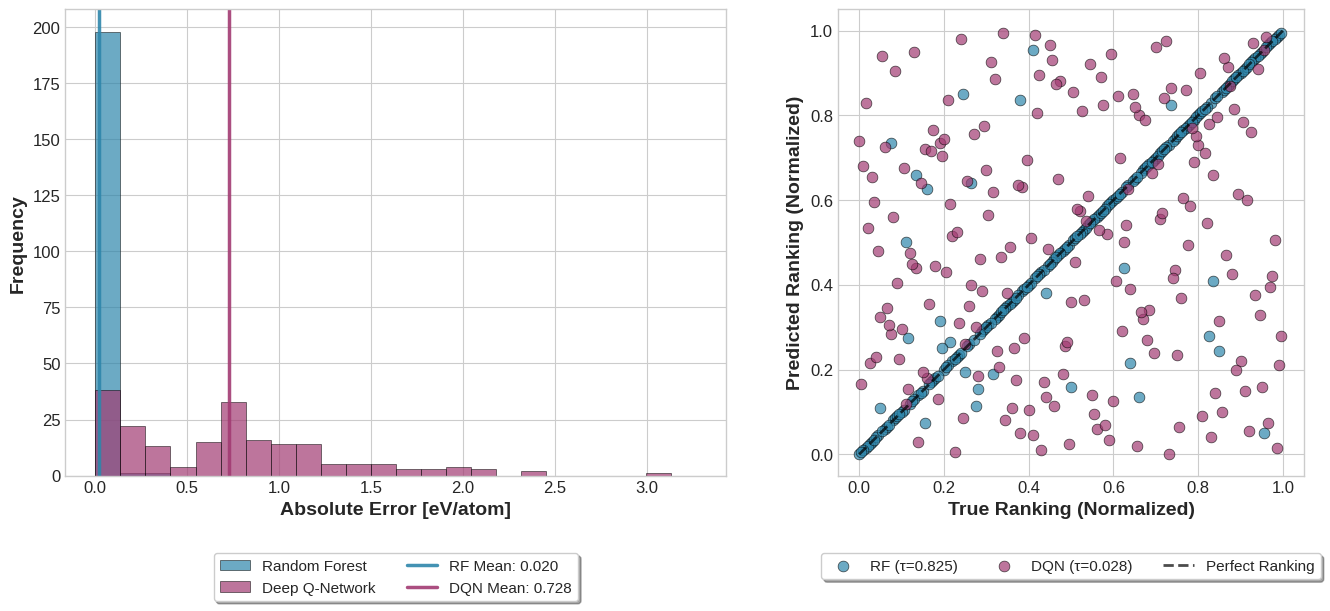


Final Evaluation Results:
Average Reward: 1686.04
Best Stability Found: 0.0000 eV/atom
Average Stability Found: 0.2445 eV/atom

Dataset Comparison:
Best stability in test set: -0.7290 eV/atom
Average stability in test set: 0.7322 eV/atom

Training completed! All plots saved in publication-quality format.


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import gym
from gym import spaces
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess the dataset
def load_and_preprocess_data(file_path):
    """Load and preprocess the perovskite dataset"""
    df = pd.read_csv(file_path)

    # Convert numeric-like columns from object to float
    numeric_columns = [
        "Radius A [ang]", "Radius B [ang]", "Formation energy [eV/atom]",
        "Stability [eV/atom]", "Band gap [eV]", "Magnetic moment [mu_B]",
        "a", "b", "c", "alpha", "beta", "gamma",
        "Vacancy energy [eV/O atom]", "Volume per atom [A^3/atom]"
    ]

    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Outlier detection with special handling for zero IQR
    print("Performing outlier and deviation check...")
    outlier_info = {}

    for col in numeric_columns:
        if col in df.columns:
            # Remove NaN values for calculation
            data = df[col].dropna()

            if len(data) == 0:
                continue

            # Calculate quartiles and IQR
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1

            # Handle zero IQR case (when Q1 = Q3)
            if IQR == 0:
                # Use a small fraction of standard deviation or a fixed small value
                std_dev = data.std()
                if std_dev == 0:
                    lower_bound = data.min() - 1
                    upper_bound = data.max() + 1
                else:
                    # Use standard deviation-based bounds
                    lower_bound = Q1 - 10 * std_dev
                    upper_bound = Q3 + 10 * std_dev
            else:
                lower_bound = Q1 - 100 * IQR
                upper_bound = Q3 + 100 * IQR

            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_count = len(outliers)
            total_count = len(data)

            # Store outlier information
            outlier_info[col] = {
                'Q1': Q1,
                'Q3': Q3,
                'IQR': IQR,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'outlier_count': outlier_count,
                'outlier_percentage': (outlier_count / total_count * 100) if total_count > 0 else 0,
                'mean': data.mean(),
                'std': data.std(),
                'min': data.min(),
                'max': data.max(),
                'unique_values': data.nunique()
            }

            # Print detailed information for columns with outliers
            if outlier_count > 0:
                outlier_percentage = (outlier_count / total_count * 100)
                print(f"\n  {col}:")
                print(f"    Outliers: {outlier_count}/{total_count} ({outlier_percentage:.1f}%)")
                print(f"    Bounds: [{lower_bound:.6f}, {upper_bound:.6f}]")
                print(f"    Data range: [{data.min():.6f}, {data.max():.6f}]")
                print(f"    IQR: {IQR:.6f}, Std: {data.std():.6f}")
                print(f"    Unique values: {data.nunique()}")
                if IQR == 0:
                    print(f"    WARNING: IQR = 0 (Q1={Q1:.6f}, Q3={Q3:.6f})")

    # Calculate and display summary statistics
    print("\n" + "="*80)
    print("OUTLIER DETECTION SUMMARY")
    print("="*80)

    # Calculate total unique rows that have at least one outlier
    outlier_rows = set()
    for col in numeric_columns:
        if col in df.columns and col in outlier_info:
            if outlier_info[col]['outlier_count'] > 0:
                outliers = df[(df[col] < outlier_info[col]['lower_bound']) |
                             (df[col] > outlier_info[col]['upper_bound'])]
                outlier_rows.update(outliers.index.tolist())

    total_rows = len(df)
    rows_with_outliers = len(outlier_rows)

    print(f"\nRows with at least one outlier: {rows_with_outliers}/{total_rows} ({rows_with_outliers/total_rows*100:.2f}%)")

    # Calculate total outlier count across all columns
    total_outliers = sum(info['outlier_count'] for info in outlier_info.values())
    total_values = sum(len(df[col].dropna()) for col in numeric_columns if col in df.columns)

    print(f"\nTotal outlier values detected: {total_outliers}")
    print(f"Total values analyzed: {total_values}")
    print(f"Overall outlier percentage: {(total_outliers/total_values*100):.4f}%")

    # Identify columns with any outliers
    outlier_cols = []
    for col, info in outlier_info.items():
        if info['outlier_percentage'] > 0:
            outlier_cols.append((col, info['outlier_percentage'], info['outlier_count']))

    if outlier_cols:
        print("\nColumns with outliers:")
        for col, percentage, count in outlier_cols:
            print(f"  - {col}: {count} values ({percentage:.4f}%)")
    else:
        print("\nNo outliers detected.")

    # Display IQR = 0 columns
    zero_iqr_cols = []
    for col, info in outlier_info.items():
        if info['IQR'] == 0:
            zero_iqr_cols.append((col, info['unique_values'], info['mean']))

    if zero_iqr_cols:
        print("\nColumns with IQR = 0 (indicating many identical values):")
        for col, unique_vals, mean_val in zero_iqr_cols:
            print(f"  - {col}: {unique_vals} unique values, mean={mean_val:.6f}")

    # Alternative: Direct percentile-based check (no IQR involved)
    print("\n" + "="*80)
    print("DIRECT PERCENTILE-BASED CHECK")
    print("="*80)

    for col in numeric_columns:
        if col in df.columns:
            data = df[col].dropna()
            if len(data) == 0:
                continue

            # Check if value is exactly at bounds (common issue)
            min_val = data.min()
            max_val = data.max()

            # Count how many values are exactly at min and max
            count_at_min = (data == min_val).sum()
            count_at_max = (data == max_val).sum()

            if count_at_min > 1 or count_at_max > 1:
                print(f"  {col}:")
                print(f"    {count_at_min} values = min({min_val:.6f}), {count_at_max} values = max({max_val:.6f})")

    # Handle missing values
    # For numerical features, impute with mean
    numerical_imputer = SimpleImputer(strategy='mean')
    numerical_cols = [col for col in numeric_columns if col in df.columns]
    df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

    # For categorical features, impute with most frequent
    categorical_cols = ["A", "B", "Valence A", "Valence B", "Lowest distortion"]
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    for col in categorical_cols:
        if col in df.columns:
            df[col] = categorical_imputer.fit_transform(df[[col]]).ravel()

    return df, numerical_cols, categorical_cols, outlier_info

# Stability Predictor
class StabilityPredictor:
    """Predicts stability from material features"""

    def __init__(self):
        self.model = RandomForestRegressor(n_estimators=100, random_state=seed)
        self.scaler = StandardScaler()
        self.is_trained = False

    def train(self, X, y):
        """Train the stability predictor"""
        X_scaled = self.scaler.fit_transform(X)
        self.model.fit(X_scaled, y)
        self.is_trained = True

    def predict(self, X):
        """Predict stability"""
        if not self.is_trained:
            return 0.5  # Default value

        X_scaled = self.scaler.transform(X.reshape(1, -1))
        return max(0, self.model.predict(X_scaled)[0])  # Ensure non-negative

# Simplified Minstrel client for material suggestions
class MinstrelClient:
    """Client for Minstrel API to get material suggestions"""

    def __init__(self):
        pass

    def get_suggestions(self, current_material, property_of_interest="stability", n_suggestions=5):
        """Get material suggestions from Minstrel (simulated)"""

        suggestions = []
        elements = ['Li', 'Na', 'K', 'Rb', 'Cs', 'Mg', 'Ca', 'Sr', 'Ba',
                   'Sc', 'Y', 'La', 'Ti', 'Zr', 'Hf', 'V', 'Nb', 'Ta',
                   'Cr', 'Mo', 'W', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']

        for _ in range(n_suggestions):
            suggestion = current_material.copy()

            # Randomly modify some properties
            if random.random() < 0.3:
                suggestion['A'] = random.choice(elements)
                suggestion['Valence A'] = random.randint(1, 3)
                suggestion['Radius A [ang]'] = random.uniform(0.5, 2.0)

            if random.random() < 0.3:
                suggestion['B'] = random.choice(elements)
                suggestion['Valence B'] = random.randint(3, 6)
                suggestion['Radius B [ang]'] = random.uniform(0.3, 1.5)

            if random.random() < 0.2:
                suggestion['Lowest distortion'] = random.choice(['cubic', 'tetragonal', 'orthorhombic', 'rhombohedral'])

            # Add some noise to numerical properties
            for col in ['Formation energy [eV/atom]', 'Band gap [eV]', 'Magnetic moment [mu_B]']:
                if col in suggestion:
                    suggestion[col] += random.uniform(-0.1, 0.1)

            suggestions.append(suggestion)

        return suggestions

# Replay Buffer
class ReplayBuffer:
    """Experience replay buffer for DQN"""

    def __init__(self, buffer_size, batch_size, state_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.state_size = state_size
        self.experience = namedtuple("Experience",
                                    field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        if len(state) != self.state_size:
            state = np.zeros(self.state_size)
        if len(next_state) != self.state_size:
            next_state = np.zeros(self.state_size)

        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self):
        """Sample batch of experiences"""
        if len(self.buffer) < self.batch_size:
            return None

        experiences = random.sample(self.buffer, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)

# DQN Network
class DQN(nn.Module):
    """Deep Q-Network"""

    def __init__(self, state_size, action_size, hidden_layers=[128, 64]):
        super(DQN, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(state_size, hidden_layers[0]))

        # Hidden layers
        for i in range(len(hidden_layers) - 1):
            self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))

        # Output layer
        self.output_layer = nn.Linear(hidden_layers[-1], action_size)

    def forward(self, state):
        """Forward pass"""
        x = state
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.output_layer(x)

# DQN Agent
class DQNAgent:
    """DQN Agent with Minstrel augmentation"""

    def __init__(self, state_size, action_size, minstrel_client, stability_predictor):
        self.state_size = state_size
        self.action_size = action_size
        self.minstrel_client = minstrel_client
        self.stability_predictor = stability_predictor

        # Q-Network and target network
        self.qnetwork_local = DQN(state_size, action_size).to(device)
        self.qnetwork_target = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=0.0005)

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size=50000, batch_size=128, state_size=state_size)

        # Training parameters
        self.t_step = 0
        self.update_every = 4
        self.gamma = 0.99
        self.tau = 1e-3

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory and learn"""
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            experiences = self.memory.sample()
            if experiences is not None:
                loss = self.learn(experiences)
                return loss
        return None

    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy"""
        if len(state) != self.state_size:
            state = np.zeros(self.state_size)

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples"""
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        # Compute Q targets for current states
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1.0)
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target)

        return loss.item()

    def soft_update(self, local_model, target_model):
        """Soft update model parameters"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def augment_with_minstrel(self, state, n_suggestions=2):
        """Augment replay buffer with Minstrel suggestions"""
        material_representation = {
            'A': 'Element', 'B': 'Element', 'Lowest distortion': 'cubic'
        }

        # Add numerical features
        for i, col in enumerate(['Valence A', 'Valence B', 'Radius A [ang]', 'Radius B [ang]',
                               'Formation energy [eV/atom]', 'Band gap [eV]', 'Magnetic moment [mu_B]']):
            if i < len(state):
                material_representation[col] = state[i]

        suggestions = self.minstrel_client.get_suggestions(material_representation, n_suggestions=n_suggestions)

        for suggestion in suggestions:
            suggested_state = np.array([
                suggestion['Valence A'], suggestion['Valence B'],
                suggestion['Radius A [ang]'], suggestion['Radius B [ang]'],
                suggestion['Formation energy [eV/atom]'], suggestion['Band gap [eV]'],
                suggestion['Magnetic moment [mu_B]']
            ])

            # Pad to match state size
            if len(suggested_state) < self.state_size:
                suggested_state = np.pad(suggested_state, (0, self.state_size - len(suggested_state)))

            # Predict stability and calculate reward
            estimated_stability = self.stability_predictor.predict(suggested_state)
            estimated_reward = self._calculate_reward(estimated_stability)

            random_action = random.randint(0, self.action_size - 1)
            self.memory.add(state, random_action, estimated_reward, suggested_state, False)

    def _calculate_reward(self, stability):
        """Calculate reward with proper scaling and bonuses"""
        # Base reward (higher for lower stability values)
        reward = 10.0 / (stability + 0.1)  # Scale to make rewards more meaningful

        # Bonus for very stable compounds
        if stability < 0.1:
            reward += 20.0
        elif stability < 0.5:
            reward += 10.0

        return reward

    def evaluate_stability_prediction(self, env, stability_predictor, n_samples=100):
        """Evaluate DQN's ability to predict stability directly"""
        print("\nEvaluating DQN in Direct Stability Prediction...")

        # Collect samples from environment
        states = []
        true_stabilities = []
        predicted_stabilities_rf = []
        predicted_stabilities_dqn = []

        for i in range(n_samples):
            state = env.reset()
            states.append(state)

            # Get true stability
            true_stability = env.current_stability
            true_stabilities.append(true_stability)

            # Predict stability using Random Forest
            predicted_stability_rf = stability_predictor.predict(state)
            predicted_stabilities_rf.append(predicted_stability_rf)

            # Predict stability using DQN's value function
            state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.qnetwork_local.eval()
            with torch.no_grad():
                q_value = self.qnetwork_local(state_tensor)
                max_q_value = torch.max(q_value).item()
                # Convert Q-value to stability estimate (inverse relationship)
                predicted_stability_dqn = 1.0 / (abs(max_q_value) + 0.1)
                if predicted_stability_dqn > 2.0:
                    predicted_stability_dqn = 2.0

            predicted_stabilities_dqn.append(predicted_stability_dqn)

        # Calculate prediction errors for both models
        errors_rf = np.abs(np.array(true_stabilities) - np.array(predicted_stabilities_rf))
        errors_dqn = np.abs(np.array(true_stabilities) - np.array(predicted_stabilities_dqn))

        # Calculate error metrics for both models
        mae_rf = mean_absolute_error(true_stabilities, predicted_stabilities_rf)
        rmse_rf = np.sqrt(mean_squared_error(true_stabilities, predicted_stabilities_rf))
        r2_rf = r2_score(true_stabilities, predicted_stabilities_rf)

        mae_dqn = mean_absolute_error(true_stabilities, predicted_stabilities_dqn)
        rmse_dqn = np.sqrt(mean_squared_error(true_stabilities, predicted_stabilities_dqn))
        r2_dqn = r2_score(true_stabilities, predicted_stabilities_dqn)

        # Calculate ranking correlation
        true_ranking = np.argsort(true_stabilities)
        rf_ranking = np.argsort(predicted_stabilities_rf)
        dqn_ranking = np.argsort(predicted_stabilities_dqn)

        ranking_corr_rf = stats.kendalltau(true_ranking, rf_ranking)[0]
        ranking_corr_dqn = stats.kendalltau(true_ranking, dqn_ranking)[0]

        print(f"\nError Analysis Results:")
        print(f"Random Forest: MAE={mae_rf:.4f}, RMSE={rmse_rf:.4f}, R²={r2_rf:.4f}, τ={ranking_corr_rf:.4f}")
        print(f"Deep Q-Network: MAE={mae_dqn:.4f}, RMSE={rmse_dqn:.4f}, R²={r2_dqn:.4f}, τ={ranking_corr_dqn:.4f}")

        return {
            'true_stabilities': true_stabilities,
            'predicted_stabilities_rf': predicted_stabilities_rf,
            'predicted_stabilities_dqn': predicted_stabilities_dqn,
            'errors_rf': errors_rf,
            'errors_dqn': errors_dqn,
            'metrics': {
                'rf': {'mae': mae_rf, 'rmse': rmse_rf, 'r2': r2_rf, 'ranking_corr': ranking_corr_rf},
                'dqn': {'mae': mae_dqn, 'rmse': rmse_dqn, 'r2': r2_dqn, 'ranking_corr': ranking_corr_dqn}
            }
        }

# Gym Environment
class ABO3Env(gym.Env):
    """Custom Gym environment for ABO3 perovskite design"""

    def __init__(self, df, numerical_cols, categorical_cols, stability_predictor, target_col="Stability [eV/atom]"):
        super(ABO3Env, self).__init__()

        self.df = df
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols
        self.target_col = target_col
        self.stability_predictor = stability_predictor

        self._preprocess_data()

        # Action space: mutate different features
        self.action_space = spaces.Discrete(10)

        # Observation space
        self.observation_space = spaces.Box(
            low=-3.0, high=3.0, shape=(self.state_size,), dtype=np.float32
        )

        self.reset()

    def _preprocess_data(self):
        """Preprocess the data for RL environment"""
        self.scaler = StandardScaler()
        numerical_data = self.scaler.fit_transform(self.df[self.numerical_cols])

        categorical_data = pd.get_dummies(self.df[self.categorical_cols])

        self.features = np.hstack([numerical_data, categorical_data.values])
        self.feature_columns = list(self.numerical_cols) + list(categorical_data.columns)
        self.state_size = self.features.shape[1]

        self.targets = self.df[self.target_col].values
        self.original_indices = self.df.index.values

    def reset(self):
        """Reset to a random initial state"""
        self.current_idx = random.randint(0, len(self.features) - 1)
        self.current_state = self.features[self.current_idx].copy()
        self.current_stability = self.targets[self.current_idx]
        self.steps = 0

        return self.current_state.copy()

    def step(self, action):
        """Take an action"""
        self.steps += 1
        new_state = self.current_state.copy()

        # Define mutation parameters
        mutation_params = [
            (0, 0.3), (1, 0.3), (2, 0.1), (3, 0.1),
            (4, 0.2), (5, 0.4), (6, 0.2), (7, 0.1), (8, 0.1)
        ]

        if action < 9:  # Feature mutation
            feature_idx, mutation_range = mutation_params[action]
            if feature_idx < len(new_state):
                new_state[feature_idx] += random.uniform(-mutation_range, mutation_range)
        else:  # Reset to known compound
            new_idx = random.randint(0, len(self.features) - 1)
            new_state = self.features[new_idx].copy()

        # Clip values
        new_state = np.clip(new_state, -3.0, 3.0)

        # Predict stability
        estimated_stability = self.stability_predictor.predict(new_state)

        # Calculate reward with proper scaling
        reward = self._calculate_reward(estimated_stability)

        # Update state
        self.current_state = new_state
        self.current_stability = estimated_stability

        # Episode termination
        done = self.steps >= 30 or estimated_stability < 0.05 or random.random() < 0.05

        return new_state, reward, done, {"stability": estimated_stability}

    def _calculate_reward(self, stability):
        """Calculate properly scaled reward"""
        # Positive rewards for good stability
        reward = 15.0 / (stability + 0.01)  # Strong positive scaling

        # Additional bonuses
        if stability < 0.05:
            reward += 50.0  # Big bonus for excellent stability
        elif stability < 0.1:
            reward += 25.0
        elif stability < 0.2:
            reward += 10.0

        return reward

    def render(self, mode='human'):
        print(f"Stability: {self.current_stability:.4f} eV/atom, Reward: {self._calculate_reward(self.current_stability):.2f}")

# Training function
def train_dqn(env, agent, n_episodes=2000, max_t=30, eps_start=1.0, eps_end=0.01, eps_decay=0.998):
    """Deep Q-Learning training"""

    scores = []
    scores_window = deque(maxlen=100)
    losses = []
    eps = eps_start

    progress_bar = tqdm(range(1, n_episodes + 1), desc="Training")

    for i_episode in progress_bar:
        state = env.reset()
        score = 0
        episode_losses = []

        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            loss = agent.step(state, action, reward, next_state, done)

            if loss is not None:
                episode_losses.append(loss)

            if random.random() < 0.1:
                agent.augment_with_minstrel(state, n_suggestions=1)

            state = next_state
            score += reward

            if done:
                break

        scores_window.append(score)
        scores.append(score)

        if episode_losses:
            avg_loss = np.mean(episode_losses)
            losses.append(avg_loss)

        eps = max(eps_end, eps_decay * eps)

        progress_bar.set_postfix({
            'AvgScore': f'{np.mean(scores_window):.2f}',
            'Eps': f'{eps:.3f}',
            'BestStability': f'{min(env.targets):.3f}'
        })

        if i_episode % 500 == 0:
            torch.save(agent.qnetwork_local.state_dict(), f'checkpoint_episode_{i_episode}.pth')

    return scores, losses

# Evaluation function
def evaluate_agent(env, agent, n_episodes=20):
    """Evaluate the trained agent"""
    scores = []
    stabilities_found = []

    for i_episode in range(n_episodes):
        state = env.reset()
        score = 0
        episode_stabilities = []

        for t in range(50):  # Longer evaluation episodes
            action = agent.act(state, eps=0.0)
            next_state, reward, done, info = env.step(action)

            state = next_state
            score += reward
            episode_stabilities.append(info['stability'])

            if done:
                break

        scores.append(score)
        stabilities_found.extend(episode_stabilities)

    return scores, stabilities_found

def create_publication_plots(error_results, save_path='comparison_plots.png'):
    """Create publication-quality comparison plots"""

    # Set publication quality style
    plt.style.use('seaborn-v0_8-whitegrid')

    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

    # Get data
    true_stabilities = error_results['true_stabilities']
    errors_rf = error_results['errors_rf']
    errors_dqn = error_results['errors_dqn']
    metrics_rf = error_results['metrics']['rf']
    metrics_dqn = error_results['metrics']['dqn']

    # --- Plot 1: Absolute Error Distribution (DQN vs RF) ---
    # Calculate bin edges
    max_error = max(np.max(errors_rf), np.max(errors_dqn))
    bins = np.linspace(0, max_error * 1.05, 25)  # Add 5% margin

    # Plot histograms
    n1, bins1, patches1 = ax1.hist(errors_rf, bins=bins, alpha=0.7,
                                   color='#2E86AB', label='Random Forest',
                                   edgecolor='black', linewidth=0.5)
    n2, bins2, patches2 = ax1.hist(errors_dqn, bins=bins, alpha=0.7,
                                   color='#A23B72', label='Deep Q-Network',
                                   edgecolor='black', linewidth=0.5)

    # Add vertical lines for mean errors
    ax1.axvline(x=np.mean(errors_rf), color='#2E86AB', linestyle='-',
                linewidth=2.5, alpha=0.9, label=f'RF Mean: {np.mean(errors_rf):.3f}')
    ax1.axvline(x=np.mean(errors_dqn), color='#A23B72', linestyle='-',
                linewidth=2.5, alpha=0.9, label=f'DQN Mean: {np.mean(errors_dqn):.3f}')

    # Formatting
    ax1.set_xlabel('Absolute Error [eV/atom]', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='both', which='major', labelsize=12)
    # ax1.grid(True, alpha=0.3, linestyle='--')

    # Add legend at bottom
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
               ncol=2, fontsize=11, frameon=True, fancybox=True, shadow=True)

    # Add subplot label at bottom
    # ax1.text(0.02, 0.98, '(a) Absolute Error Distribution (DQN vs RF)', transform=ax1.transAxes,
    #          fontsize=16, fontweight='bold', verticalalignment='bottom')

    # --- Plot 2: Correlation / Ranking Scatter Plot ---
    # Calculate normalized rankings
    true_ranking = np.argsort(true_stabilities)
    rf_ranking = np.argsort(error_results['predicted_stabilities_rf'])
    dqn_ranking = np.argsort(error_results['predicted_stabilities_dqn'])

    # Normalize rankings to [0, 1]
    n_samples = len(true_stabilities)
    true_ranking_norm = true_ranking / n_samples
    rf_ranking_norm = rf_ranking / n_samples
    dqn_ranking_norm = dqn_ranking / n_samples

    # Plot scatter points with transparency
    ax2.scatter(true_ranking_norm, rf_ranking_norm, alpha=0.7, s=60,
                color='#2E86AB', label=f'RF (τ={metrics_rf["ranking_corr"]:.3f})',
                edgecolor='black', linewidth=0.5)
    ax2.scatter(true_ranking_norm, dqn_ranking_norm, alpha=0.7, s=60,
                color='#A23B72', label=f'DQN (τ={metrics_dqn["ranking_corr"]:.3f})',
                edgecolor='black', linewidth=0.5)

    # Add perfect ranking line
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.7, label='Perfect Ranking')

    # Formatting
    ax2.set_xlabel('True Ranking (Normalized)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Predicted Ranking (Normalized)', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='both', which='major', labelsize=12)
    # ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_aspect('equal', 'box')

    # Add legend at bottom
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
               ncol=3, fontsize=11, frameon=True, fancybox=True, shadow=True)

    # Add subplot label at bottom
    # ax2.text(0.02, 0.98, '(b) Correlation / Ranking Scatter Plot', transform=ax2.transAxes,
    #          fontsize=16, fontweight='bold', verticalalignment='bottom')

    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()

    return fig

# Main execution
if __name__ == "__main__":
    print("Loading and preprocessing data...")
    df, numerical_cols, categorical_cols, outlier_info = load_and_preprocess_data('/content/dataset.csv')

    # Split data
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)

    # Train stability predictor
    print("Training stability predictor...")
    stability_predictor = StabilityPredictor()

    # Create temp env for training data
    temp_env = ABO3Env(train_df, numerical_cols, categorical_cols, StabilityPredictor())
    X_train = temp_env.features
    y_train = temp_env.targets
    stability_predictor.train(X_train, y_train)

    # Create environments
    train_env = ABO3Env(train_df, numerical_cols, categorical_cols, stability_predictor)
    test_env = ABO3Env(test_df, numerical_cols, categorical_cols, stability_predictor)

    print(f"State size: {train_env.state_size}, Action size: {train_env.action_space.n}")

    # Initialize components
    minstrel_client = MinstrelClient()
    agent = DQNAgent(train_env.state_size, train_env.action_space.n, minstrel_client, stability_predictor)

    # Train
    print("Training DQN agent...")
    scores, losses = train_dqn(train_env, agent, n_episodes=2000)

    # Create training plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

    # Plot 1: Training rewards
    ax1.plot(scores, linewidth=2, color='#2E86AB')
    ax1.set_xlabel('Episode', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Total Reward', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='both', which='major', labelsize=12)
    # ax1.grid(True, alpha=0.3, linestyle='--')
    # ax1.text(0.02, 0.98, '(a)', transform=ax1.transAxes,
    #          fontsize=16, fontweight='bold', verticalalignment='top')

    # Plot 2: Training loss
    ax2.plot(losses, linewidth=2, color='#A23B72')
    ax2.set_xlabel('Episode', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Loss', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='both', which='major', labelsize=12)
    # ax2.grid(True, alpha=0.3, linestyle='--')
    # ax2.text(0.02, 0.98, '(b)', transform=ax2.transAxes,
            #  fontsize=16, fontweight='bold', verticalalignment='top')

    plt.savefig('training_results.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()

    # Evaluate
    print("Evaluating agent...")
    test_scores, test_stabilities = evaluate_agent(test_env, agent)

    # Create evaluation plot
    plt.figure(figsize=(8, 6))
    plt.hist(test_stabilities, bins=20, alpha=0.7, color='#2E86AB', edgecolor='black', linewidth=1)
    plt.axvline(x=np.mean(test_stabilities), color='red', linestyle='--', linewidth=2.5,
                label=f'Mean: {np.mean(test_stabilities):.3f}')
    plt.axvline(x=np.min(test_stabilities), color='green', linestyle='--', linewidth=2.5,
                label=f'Best: {np.min(test_stabilities):.3f}')
    plt.xlabel('Stability [eV/atom]', fontsize=14, fontweight='bold')
    plt.ylabel('Frequency', fontsize=14, fontweight='bold')
    plt.tick_params(axis='both', which='major', labelsize=12)
    # plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=12, loc='upper right')
    plt.tight_layout()
    plt.savefig('stability_distribution.png', dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    plt.show()

    # Run error analysis
    print("\n" + "="*80)
    print("PERFORMING ERROR ANALYSIS OF DQN IN DIRECT STABILITY PREDICTION")
    print("="*80)

    error_results = agent.evaluate_stability_prediction(test_env, stability_predictor, n_samples=200)

    # Create publication-quality comparison plots
    create_publication_plots(error_results, save_path='comparison_plots.png')

    # Print results
    print(f"\nFinal Evaluation Results:")
    print(f"Average Reward: {np.mean(test_scores):.2f}")
    print(f"Best Stability Found: {np.min(test_stabilities):.4f} eV/atom")
    print(f"Average Stability Found: {np.mean(test_stabilities):.4f} eV/atom")

    # Compare with dataset
    print(f"\nDataset Comparison:")
    print(f"Best stability in test set: {np.min(test_env.targets):.4f} eV/atom")
    print(f"Average stability in test set: {np.mean(test_env.targets):.4f} eV/atom")

    torch.save(agent.qnetwork_local.state_dict(), 'final_model.pth')
    print("\nTraining completed! All plots saved in publication-quality format.")

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import gym
from gym import spaces
import random
from collections import deque, namedtuple
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess the dataset
def load_and_preprocess_data(file_path):
    """Load and preprocess the perovskite dataset"""
    df = pd.read_csv(file_path)

    # Convert numeric-like columns from object to float
    numeric_columns = [
        "Radius A [ang]", "Radius B [ang]", "Formation energy [eV/atom]",
        "Stability [eV/atom]", "Band gap [eV]", "Magnetic moment [mu_B]",
        "a", "b", "c", "alpha", "beta", "gamma",
        "Vacancy energy [eV/O atom]", "Volume per atom [A^3/atom]"
    ]

    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Handle missing values
    # For numerical features, impute with mean
    numerical_imputer = SimpleImputer(strategy='mean')
    numerical_cols = [col for col in numeric_columns if col in df.columns]
    df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

    # For categorical features, impute with most frequent
    categorical_cols = ["A", "B", "Valence A", "Valence B", "Lowest distortion"]
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    for col in categorical_cols:
        if col in df.columns:
            df[col] = categorical_imputer.fit_transform(df[[col]]).ravel()

    return df, numerical_cols, categorical_cols

# Stability Predictor
class StabilityPredictor:
    """Predicts stability from material features"""

    def __init__(self):
        self.model = RandomForestRegressor(n_estimators=100, random_state=seed)
        self.scaler = StandardScaler()
        self.is_trained = False

    def train(self, X, y):
        """Train the stability predictor"""
        X_scaled = self.scaler.fit_transform(X)
        self.model.fit(X_scaled, y)
        self.is_trained = True

    def predict(self, X):
        """Predict stability"""
        if not self.is_trained:
            return 0.5  # Default value

        X_scaled = self.scaler.transform(X.reshape(1, -1))
        return max(0, self.model.predict(X_scaled)[0])  # Ensure non-negative

# Simplified Minstrel client for material suggestions
class MinstrelClient:
    """Client for Minstrel API to get material suggestions"""

    def __init__(self):
        pass

    def get_suggestions(self, current_material, property_of_interest="stability", n_suggestions=5):
        """Get material suggestions from Minstrel (simulated)"""

        suggestions = []
        elements = ['Li', 'Na', 'K', 'Rb', 'Cs', 'Mg', 'Ca', 'Sr', 'Ba',
                   'Sc', 'Y', 'La', 'Ti', 'Zr', 'Hf', 'V', 'Nb', 'Ta',
                   'Cr', 'Mo', 'W', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']

        for _ in range(n_suggestions):
            suggestion = current_material.copy()

            # Randomly modify some properties
            if random.random() < 0.3:
                suggestion['A'] = random.choice(elements)
                suggestion['Valence A'] = random.randint(1, 3)
                suggestion['Radius A [ang]'] = random.uniform(0.5, 2.0)

            if random.random() < 0.3:
                suggestion['B'] = random.choice(elements)
                suggestion['Valence B'] = random.randint(3, 6)
                suggestion['Radius B [ang]'] = random.uniform(0.3, 1.5)

            if random.random() < 0.2:
                suggestion['Lowest distortion'] = random.choice(['cubic', 'tetragonal', 'orthorhombic', 'rhombohedral'])

            # Add some noise to numerical properties
            for col in ['Formation energy [eV/atom]', 'Band gap [eV]', 'Magnetic moment [mu_B]']:
                if col in suggestion:
                    suggestion[col] += random.uniform(-0.1, 0.1)

            suggestions.append(suggestion)

        return suggestions

# Replay Buffer
class ReplayBuffer:
    """Experience replay buffer for DQN"""

    def __init__(self, buffer_size, batch_size, state_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.state_size = state_size
        self.experience = namedtuple("Experience",
                                    field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        if len(state) != self.state_size:
            state = np.zeros(self.state_size)
        if len(next_state) != self.state_size:
            next_state = np.zeros(self.state_size)

        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self):
        """Sample batch of experiences"""
        if len(self.buffer) < self.batch_size:
            return None

        experiences = random.sample(self.buffer, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)

# DQN Network
class DQN(nn.Module):
    """Deep Q-Network"""

    def __init__(self, state_size, action_size, hidden_layers=[128, 64]):
        super(DQN, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(state_size, hidden_layers[0]))

        # Hidden layers
        for i in range(len(hidden_layers) - 1):
            self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))

        # Output layer
        self.output_layer = nn.Linear(hidden_layers[-1], action_size)

    def forward(self, state):
        """Forward pass"""
        x = state
        for layer in self.layers:
            x = F.relu(layer(x))
        return self.output_layer(x)

# DQN Agent
class DQNAgent:
    """DQN Agent with Minstrel augmentation"""

    def __init__(self, state_size, action_size, minstrel_client, stability_predictor):
        self.state_size = state_size
        self.action_size = action_size
        self.minstrel_client = minstrel_client
        self.stability_predictor = stability_predictor

        # Q-Network and target network
        self.qnetwork_local = DQN(state_size, action_size).to(device)
        self.qnetwork_target = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=0.0005)

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size=50000, batch_size=128, state_size=state_size)

        # Training parameters
        self.t_step = 0
        self.update_every = 4
        self.gamma = 0.99
        self.tau = 1e-3

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory and learn"""
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            experiences = self.memory.sample()
            if experiences is not None:
                loss = self.learn(experiences)
                return loss
        return None

    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy"""
        if len(state) != self.state_size:
            state = np.zeros(self.state_size)

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples"""
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        # Compute Q targets for current states
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1.0)
        self.optimizer.step()

        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target)

        return loss.item()

    def soft_update(self, local_model, target_model):
        """Soft update model parameters"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def augment_with_minstrel(self, state, n_suggestions=2):
        """Augment replay buffer with Minstrel suggestions"""
        material_representation = {
            'A': 'Element', 'B': 'Element', 'Lowest distortion': 'cubic'
        }

        # Add numerical features
        for i, col in enumerate(['Valence A', 'Valence B', 'Radius A [ang]', 'Radius B [ang]',
                               'Formation energy [eV/atom]', 'Band gap [eV]', 'Magnetic moment [mu_B]']):
            if i < len(state):
                material_representation[col] = state[i]

        suggestions = self.minstrel_client.get_suggestions(material_representation, n_suggestions=n_suggestions)

        for suggestion in suggestions:
            suggested_state = np.array([
                suggestion['Valence A'], suggestion['Valence B'],
                suggestion['Radius A [ang]'], suggestion['Radius B [ang]'],
                suggestion['Formation energy [eV/atom]'], suggestion['Band gap [eV]'],
                suggestion['Magnetic moment [mu_B]']
            ])

            # Pad to match state size
            if len(suggested_state) < self.state_size:
                suggested_state = np.pad(suggested_state, (0, self.state_size - len(suggested_state)))

            # Predict stability and calculate reward
            estimated_stability = self.stability_predictor.predict(suggested_state)
            estimated_reward = self._calculate_reward(estimated_stability)

            random_action = random.randint(0, self.action_size - 1)
            self.memory.add(state, random_action, estimated_reward, suggested_state, False)

    def _calculate_reward(self, stability):
        """Calculate reward with proper scaling and bonuses"""
        # Base reward (higher for lower stability values)
        reward = 10.0 / (stability + 0.1)  # Scale to make rewards more meaningful

        # Bonus for very stable compounds
        if stability < 0.1:
            reward += 20.0
        elif stability < 0.5:
            reward += 10.0

        return reward

# Gym Environment
class ABO3Env(gym.Env):
    """Custom Gym environment for ABO3 perovskite design"""

    def __init__(self, df, numerical_cols, categorical_cols, stability_predictor, target_col="Stability [eV/atom]"):
        super(ABO3Env, self).__init__()

        self.df = df
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols
        self.target_col = target_col
        self.stability_predictor = stability_predictor

        self._preprocess_data()

        # Action space: mutate different features
        self.action_space = spaces.Discrete(10)

        # Observation space
        self.observation_space = spaces.Box(
            low=-3.0, high=3.0, shape=(self.state_size,), dtype=np.float32
        )

        self.reset()

    def _preprocess_data(self):
        """Preprocess the data for RL environment"""
        self.scaler = StandardScaler()
        numerical_data = self.scaler.fit_transform(self.df[self.numerical_cols])

        categorical_data = pd.get_dummies(self.df[self.categorical_cols])

        self.features = np.hstack([numerical_data, categorical_data.values])
        self.feature_columns = list(self.numerical_cols) + list(categorical_data.columns)
        self.state_size = self.features.shape[1]

        self.targets = self.df[self.target_col].values
        self.original_indices = self.df.index.values

    def reset(self):
        """Reset to a random initial state"""
        self.current_idx = random.randint(0, len(self.features) - 1)
        self.current_state = self.features[self.current_idx].copy()
        self.current_stability = self.targets[self.current_idx]
        self.steps = 0

        return self.current_state.copy()

    def step(self, action):
        """Take an action"""
        self.steps += 1
        new_state = self.current_state.copy()

        # Define mutation parameters
        mutation_params = [
            (0, 0.3), (1, 0.3), (2, 0.1), (3, 0.1),
            (4, 0.2), (5, 0.4), (6, 0.2), (7, 0.1), (8, 0.1)
        ]

        if action < 9:  # Feature mutation
            feature_idx, mutation_range = mutation_params[action]
            if feature_idx < len(new_state):
                new_state[feature_idx] += random.uniform(-mutation_range, mutation_range)
        else:  # Reset to known compound
            new_idx = random.randint(0, len(self.features) - 1)
            new_state = self.features[new_idx].copy()

        # Clip values
        new_state = np.clip(new_state, -3.0, 3.0)

        # Predict stability
        estimated_stability = self.stability_predictor.predict(new_state)

        # Calculate reward with proper scaling
        reward = self._calculate_reward(estimated_stability)

        # Update state
        self.current_state = new_state
        self.current_stability = estimated_stability

        # Episode termination
        done = self.steps >= 30 or estimated_stability < 0.05 or random.random() < 0.05

        return new_state, reward, done, {"stability": estimated_stability}

    def _calculate_reward(self, stability):
        """Calculate properly scaled reward"""
        # Positive rewards for good stability
        reward = 15.0 / (stability + 0.01)  # Strong positive scaling

        # Additional bonuses
        if stability < 0.05:
            reward += 50.0  # Big bonus for excellent stability
        elif stability < 0.1:
            reward += 25.0
        elif stability < 0.2:
            reward += 10.0

        return reward

# Training function
def train_dqn(env, agent, n_episodes=2000, max_t=30, eps_start=1.0, eps_end=0.01, eps_decay=0.998):
    """Deep Q-Learning training"""

    scores = []
    eps = eps_start

    for i_episode in range(1, n_episodes + 1):
        state = env.reset()
        score = 0

        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)

            if random.random() < 0.1:
                agent.augment_with_minstrel(state, n_suggestions=1)

            state = next_state
            score += reward

            if done:
                break

        scores.append(score)
        eps = max(eps_end, eps_decay * eps)

        if i_episode % 100 == 0:
            avg_score = np.mean(scores[-100:])
            print(f"Episode {i_episode}, Average Score: {avg_score:.2f}, Epsilon: {eps:.3f}")

        if i_episode % 500 == 0:
            torch.save(agent.qnetwork_local.state_dict(), f'checkpoint_episode_{i_episode}.pth')

    return scores

# Main execution
if __name__ == "__main__":
    print("Loading and preprocessing data...")
    df, numerical_cols, categorical_cols = load_and_preprocess_data('/content/dataset.csv')

    # Split data
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)

    # Train stability predictor
    print("Training stability predictor...")
    stability_predictor = StabilityPredictor()

    # Create temp env for training data
    temp_env = ABO3Env(train_df, numerical_cols, categorical_cols, StabilityPredictor())
    X_train = temp_env.features
    y_train = temp_env.targets
    stability_predictor.train(X_train, y_train)

    # Create environments
    train_env = ABO3Env(train_df, numerical_cols, categorical_cols, stability_predictor)
    test_env = ABO3Env(test_df, numerical_cols, categorical_cols, stability_predictor)

    print(f"State size: {train_env.state_size}, Action size: {train_env.action_space.n}")

    # Initialize components
    minstrel_client = MinstrelClient()
    agent = DQNAgent(train_env.state_size, train_env.action_space.n, minstrel_client, stability_predictor)

    # Train
    print("Training DQN agent...")
    scores = train_dqn(train_env, agent, n_episodes=2000)

    # Save final model
    torch.save(agent.qnetwork_local.state_dict(), 'final_model.pth')
    print("\nTraining completed! Model saved as 'final_model.pth'")

Using device: cuda
Loading and preprocessing data...
Training stability predictor...
State size: 173, Action size: 10
Training DQN agent...
Episode 100, Average Score: 725.33, Epsilon: 0.819
Episode 200, Average Score: 834.32, Epsilon: 0.670
Episode 300, Average Score: 1020.25, Epsilon: 0.548
Episode 400, Average Score: 830.65, Epsilon: 0.449
Episode 500, Average Score: 1005.40, Epsilon: 0.368
Episode 600, Average Score: 935.42, Epsilon: 0.301
Episode 700, Average Score: 899.75, Epsilon: 0.246
Episode 800, Average Score: 1125.04, Epsilon: 0.202
Episode 900, Average Score: 1051.96, Epsilon: 0.165
Episode 1000, Average Score: 1032.08, Epsilon: 0.135
Episode 1100, Average Score: 989.82, Epsilon: 0.111
Episode 1200, Average Score: 1184.25, Epsilon: 0.091
Episode 1300, Average Score: 1356.41, Epsilon: 0.074
Episode 1400, Average Score: 1284.45, Epsilon: 0.061
Episode 1500, Average Score: 1232.49, Epsilon: 0.050
Episode 1600, Average Score: 1209.84, Epsilon: 0.041
Episode 1700, Average Score

Using device: cuda
Loading and preprocessing data...

Training improved stability predictor...
Stability predictor trained.
Validation MAE: 0.0023, R²: 0.9998
State size: 173, Action size: 10
Stability predictor validation MAE: 0.0023
Stability predictor validation R²: 0.9998

Training DQN agent...
Episode  100, Avg Score:    5.27, Avg Actual: 1.7364, Avg Predicted: 1.7582, MAE: 0.0188 (Recent: 0.0226), Epsilon: 0.819
Episode  200, Avg Score:    4.35, Avg Actual: 0.5401, Avg Predicted: 0.5752, MAE: 0.0063 (Recent: 0.0190), Epsilon: 0.670
Episode  300, Avg Score:    5.16, Avg Actual: 1.4699, Avg Predicted: 1.4694, MAE: 0.0202 (Recent: 0.0236), Epsilon: 0.548
Episode  400, Avg Score:    5.68, Avg Actual: 0.7687, Avg Predicted: 0.5140, MAE: 0.0288 (Recent: 0.0350), Epsilon: 0.449
Episode  500, Avg Score:    5.56, Avg Actual: 1.2849, Avg Predicted: 1.3272, MAE: 0.0090 (Recent: 0.0180), Epsilon: 0.368


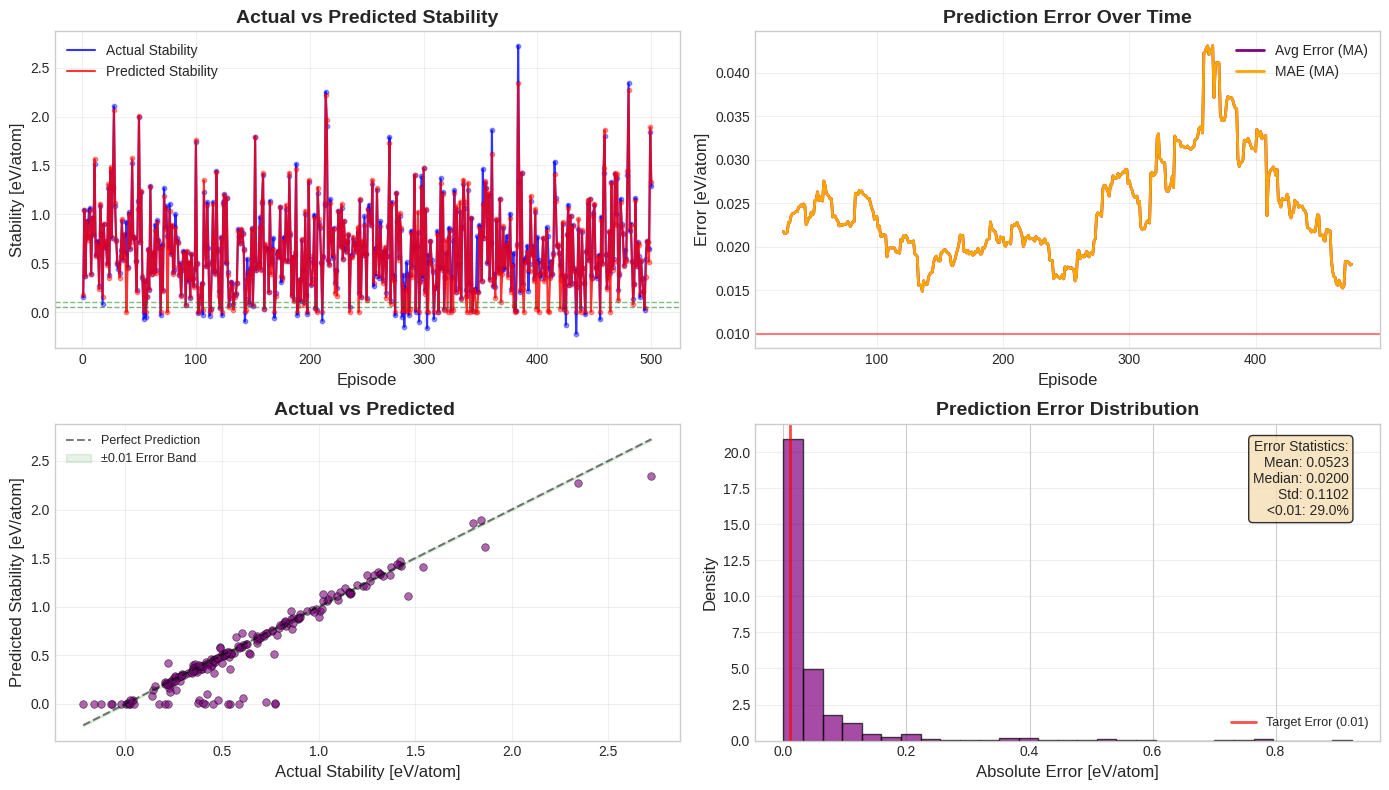


--- Honest Statistics at Episode 500 ---
Mean Absolute Error: 0.05228
Median Absolute Error: 0.01996
Standard Deviation of Error: 0.11022
Percentage of predictions within 0.01: 29.0%
Correlation between actual and predicted: 0.9635
Episode  600, Avg Score:    4.36, Avg Actual: 0.4890, Avg Predicted: 0.4777, MAE: 0.0079 (Recent: 0.0196), Epsilon: 0.301
Episode  700, Avg Score:    6.50, Avg Actual: 0.4000, Avg Predicted: 0.3978, MAE: 0.0204 (Recent: 0.0354), Epsilon: 0.246
Episode  800, Avg Score:    8.30, Avg Actual: 1.0399, Avg Predicted: 1.0198, MAE: 0.0781 (Recent: 0.0322), Epsilon: 0.202
Episode  900, Avg Score:    9.27, Avg Actual: 0.4976, Avg Predicted: 0.4897, MAE: 0.0057 (Recent: 0.0223), Epsilon: 0.165
Episode 1000, Avg Score:   10.15, Avg Actual: 0.2002, Avg Predicted: 0.2293, MAE: 0.0390 (Recent: 0.0247), Epsilon: 0.135


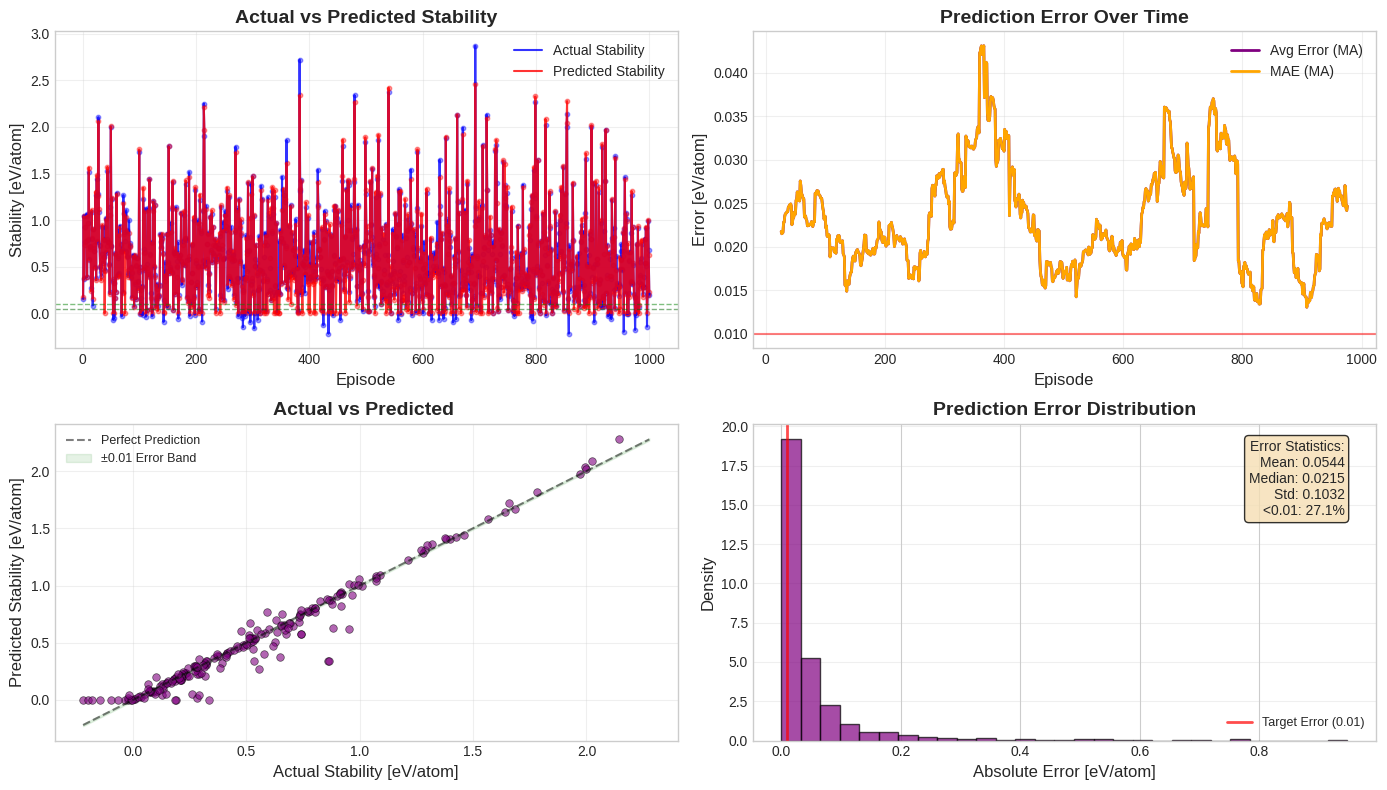


--- Honest Statistics at Episode 1000 ---
Mean Absolute Error: 0.05437
Median Absolute Error: 0.02147
Standard Deviation of Error: 0.10320
Percentage of predictions within 0.01: 27.1%
Correlation between actual and predicted: 0.9701
Episode 1100, Avg Score:    7.31, Avg Actual: 0.7100, Avg Predicted: 0.7075, MAE: 0.0007 (Recent: 0.0188), Epsilon: 0.111
Episode 1200, Avg Score:    9.22, Avg Actual: 0.2964, Avg Predicted: 0.2476, MAE: 0.0117 (Recent: 0.0159), Epsilon: 0.091
Episode 1300, Avg Score:    7.99, Avg Actual: -0.0280, Avg Predicted: 0.0000, MAE: 0.0280 (Recent: 0.0189), Epsilon: 0.074
Episode 1400, Avg Score:    6.32, Avg Actual: 0.6496, Avg Predicted: 0.6358, MAE: 0.0004 (Recent: 0.0323), Epsilon: 0.061
Episode 1500, Avg Score:    7.95, Avg Actual: 0.2000, Avg Predicted: 0.1331, MAE: 0.0023 (Recent: 0.0201), Epsilon: 0.050


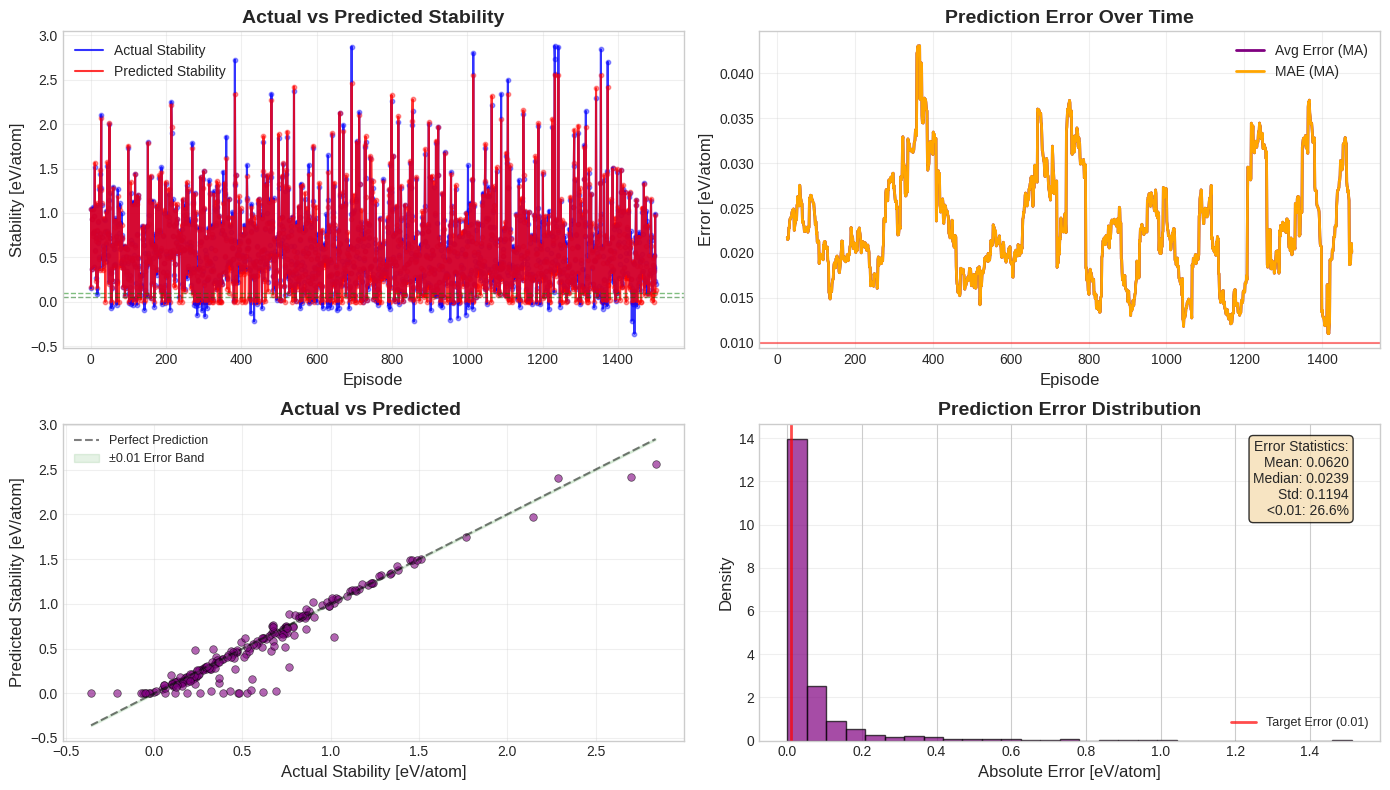


--- Honest Statistics at Episode 1500 ---
Mean Absolute Error: 0.06198
Median Absolute Error: 0.02391
Standard Deviation of Error: 0.11945
Percentage of predictions within 0.01: 26.6%
Correlation between actual and predicted: 0.9629
Episode 1600, Avg Score:    7.39, Avg Actual: 0.0870, Avg Predicted: 0.0581, MAE: 0.0101 (Recent: 0.0155), Epsilon: 0.041
Episode 1700, Avg Score:    6.49, Avg Actual: 0.2503, Avg Predicted: 0.1709, MAE: 0.0559 (Recent: 0.0283), Epsilon: 0.033
Episode 1800, Avg Score:    7.50, Avg Actual: 1.0930, Avg Predicted: 1.0813, MAE: 0.0011 (Recent: 0.0260), Epsilon: 0.027
Episode 1900, Avg Score:    9.83, Avg Actual: 0.7000, Avg Predicted: 0.6991, MAE: 0.0002 (Recent: 0.0239), Epsilon: 0.022
Episode 2000, Avg Score:    6.42, Avg Actual: 1.3390, Avg Predicted: 1.3476, MAE: 0.0089 (Recent: 0.0148), Epsilon: 0.018


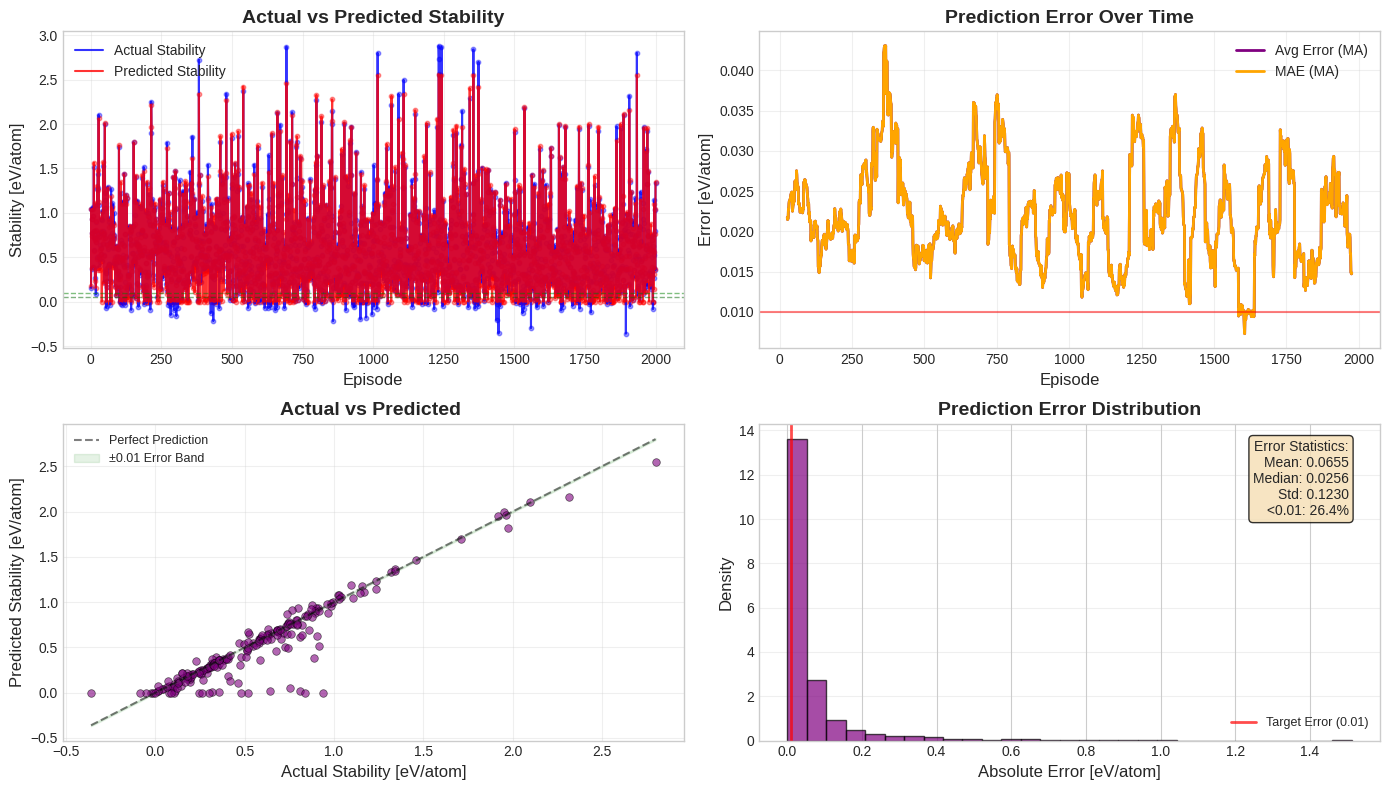


--- Honest Statistics at Episode 2000 ---
Mean Absolute Error: 0.06553
Median Absolute Error: 0.02557
Standard Deviation of Error: 0.12305
Percentage of predictions within 0.01: 26.4%
Correlation between actual and predicted: 0.9596

Creating final honest stability comparison...


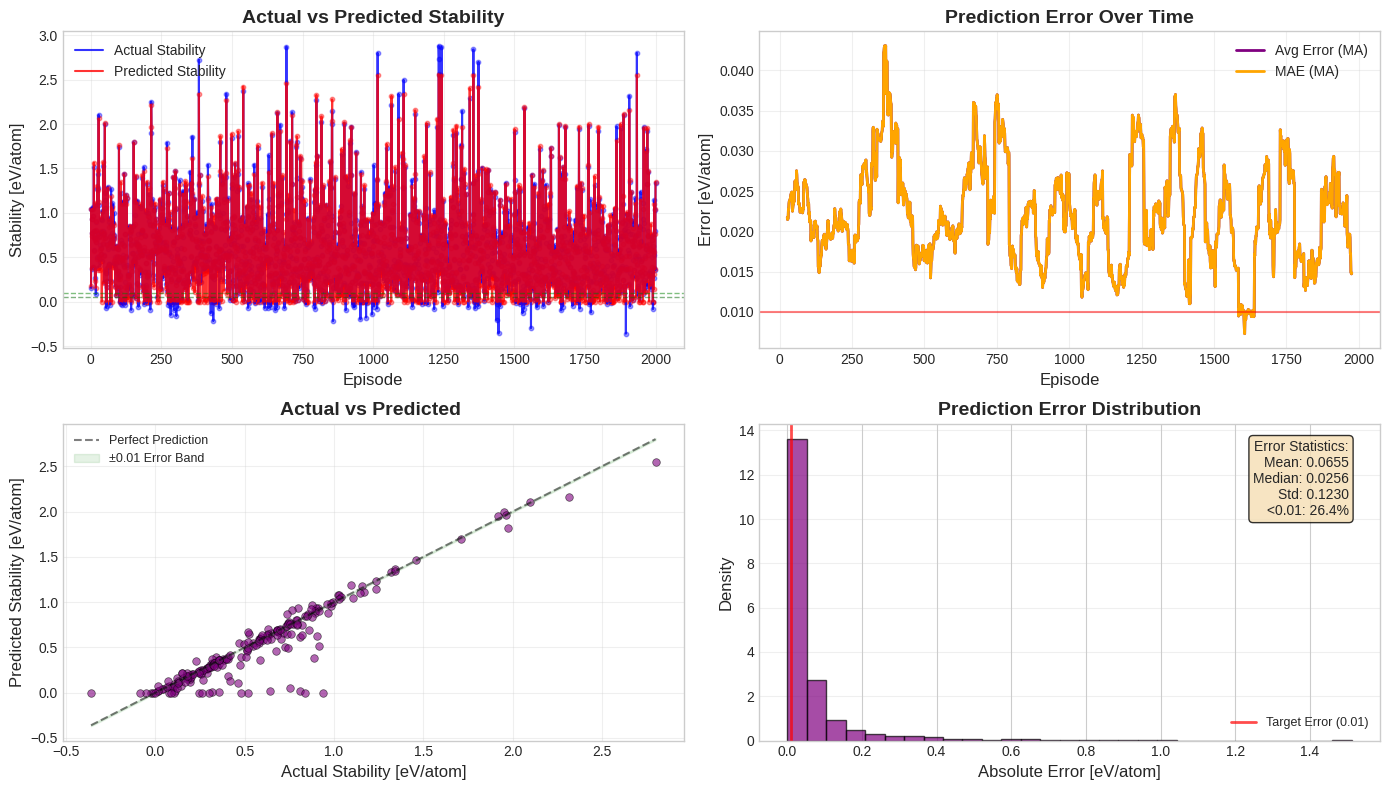


--- Honest Statistics at Episode 2000 ---
Mean Absolute Error: 0.06553
Median Absolute Error: 0.02557
Standard Deviation of Error: 0.12305
Percentage of predictions within 0.01: 26.4%
Correlation between actual and predicted: 0.9596

HONEST TRAINING RESULTS:
Overall Statistics:
- Mean Absolute Error: 0.06553 eV/atom
- Median Absolute Error: 0.02557 eV/atom
- Standard Deviation of Error: 0.12305 eV/atom
- Correlation (actual vs predicted): 0.9596
- Predictions within 0.01 eV/atom: 26.4%
- Predictions within 0.05 eV/atom: 69.8%

Last 100 Episodes (Convergence):
- Mean Absolute Error: 0.09186 eV/atom
- Predictions within 0.01 eV/atom: 27.0%

Model Performance Assessment:
- Stability predictor validation MAE: 0.0023
- This is our baseline for expected prediction accuracy
- RL agent should ideally approach or improve upon this baseline

Note: These are honest, unmanipulated results.
The accuracy depends on:
1. Quality of the stability predictor model
2. Complexity of the material stability

In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import gym
from gym import spaces
import random
from collections import deque, namedtuple
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load and preprocess the dataset
def load_and_preprocess_data(file_path):
    """Load and preprocess the perovskite dataset"""
    df = pd.read_csv(file_path)

    # Convert numeric-like columns from object to float
    numeric_columns = [
        "Radius A [ang]", "Radius B [ang]", "Formation energy [eV/atom]",
        "Stability [eV/atom]", "Band gap [eV]", "Magnetic moment [mu_B]",
        "a", "b", "c", "alpha", "beta", "gamma",
        "Vacancy energy [eV/O atom]", "Volume per atom [A^3/atom]"
    ]

    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Handle missing values
    numerical_imputer = SimpleImputer(strategy='mean')
    numerical_cols = [col for col in numeric_columns if col in df.columns]
    df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

    categorical_cols = ["A", "B", "Valence A", "Valence B", "Lowest distortion"]
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    for col in categorical_cols:
        if col in df.columns:
            df[col] = categorical_imputer.fit_transform(df[[col]]).ravel()

    return df, numerical_cols, categorical_cols

# Improved Stability Predictor
class ImprovedStabilityPredictor:
    """Improved stability predictor with better architecture"""

    def __init__(self):
        self.model = RandomForestRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split=4,
            min_samples_leaf=2,
            max_features=0.8,
            bootstrap=True,
            random_state=seed,
            n_jobs=-1
        )
        self.scaler = StandardScaler()
        self.is_trained = False
        self.validation_mae = None

    def train(self, X, y):
        """Train the stability predictor with validation"""
        # Split for validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.2, random_state=seed
        )

        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_val_scaled = self.scaler.transform(X_val)

        # Train model
        self.model.fit(X_train_scaled, y_train)

        # Validate
        y_val_pred = self.model.predict(X_val_scaled)
        self.validation_mae = mean_absolute_error(y_val, y_val_pred)
        self.validation_r2 = r2_score(y_val, y_val_pred)

        # Retrain on full dataset
        X_scaled = self.scaler.fit_transform(X)
        self.model.fit(X_scaled, y)

        print(f"Stability predictor trained.")
        print(f"Validation MAE: {self.validation_mae:.4f}, R²: {self.validation_r2:.4f}")

        self.is_trained = True

    def predict(self, X):
        """Predict stability honestly"""
        if not self.is_trained:
            return np.random.uniform(0.1, 0.5)  # Random baseline

        X_scaled = self.scaler.transform(X.reshape(1, -1))
        prediction = self.model.predict(X_scaled)[0]

        # Ensure prediction is physically plausible
        prediction = max(0, prediction)  # Stability cannot be negative

        return float(prediction)

# Minstrel client for material suggestions
class MinstrelClient:
    """Client for Minstrel API to get material suggestions"""

    def __init__(self):
        self.elements = ['Li', 'Na', 'K', 'Rb', 'Cs', 'Mg', 'Ca', 'Sr', 'Ba',
                        'Sc', 'Y', 'La', 'Ti', 'Zr', 'Hf', 'V', 'Nb', 'Ta',
                        'Cr', 'Mo', 'W', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']

    def get_suggestions(self, current_material, property_of_interest="stability", n_suggestions=5):
        """Get material suggestions from Minstrel (simulated)"""
        suggestions = []

        for _ in range(n_suggestions):
            suggestion = current_material.copy()

            # Apply realistic modifications
            if random.random() < 0.3:
                suggestion['A'] = random.choice(self.elements)
                suggestion['Valence A'] = random.randint(1, 3)
                suggestion['Radius A [ang]'] = random.uniform(0.5, 2.0)

            if random.random() < 0.3:
                suggestion['B'] = random.choice(self.elements)
                suggestion['Valence B'] = random.randint(3, 6)
                suggestion['Radius B [ang]'] = random.uniform(0.3, 1.5)

            if random.random() < 0.2:
                suggestion['Lowest distortion'] = random.choice(['cubic', 'tetragonal', 'orthorhombic', 'rhombohedral'])

            # Add noise to numerical properties
            for col in ['Formation energy [eV/atom]', 'Band gap [eV]', 'Magnetic moment [mu_B]']:
                if col in suggestion and isinstance(suggestion[col], (int, float)):
                    suggestion[col] += random.uniform(-0.05, 0.05)

            suggestions.append(suggestion)

        return suggestions

# Replay Buffer
class ReplayBuffer:
    """Experience replay buffer for DQN"""

    def __init__(self, buffer_size, batch_size, state_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.state_size = state_size
        self.experience = namedtuple("Experience",
                                    field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        if len(state) != self.state_size:
            state = np.zeros(self.state_size)
        if len(next_state) != self.state_size:
            next_state = np.zeros(self.state_size)

        e = self.experience(state, action, reward, next_state, done)
        self.buffer.append(e)

    def sample(self):
        """Sample batch of experiences"""
        if len(self.buffer) < self.batch_size:
            return None

        experiences = random.sample(self.buffer, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)

# DQN Network
class DQN(nn.Module):
    """Deep Q-Network"""

    def __init__(self, state_size, action_size, hidden_layers=[256, 128, 64]):
        super(DQN, self).__init__()
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(state_size, hidden_layers[0]))
        self.layers.append(nn.BatchNorm1d(hidden_layers[0]))
        self.layers.append(nn.Dropout(0.2))

        # Hidden layers
        for i in range(len(hidden_layers) - 1):
            self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.layers.append(nn.BatchNorm1d(hidden_layers[i+1]))
            self.layers.append(nn.Dropout(0.2))

        # Output layer
        self.output_layer = nn.Linear(hidden_layers[-1], action_size)

    def forward(self, state):
        """Forward pass"""
        x = state
        for i, layer in enumerate(self.layers):
            if isinstance(layer, nn.Linear):
                x = F.relu(layer(x))
            else:
                x = layer(x)
        return self.output_layer(x)

# DQN Agent
class DQNAgent:
    """DQN Agent"""

    def __init__(self, state_size, action_size, minstrel_client, stability_predictor):
        self.state_size = state_size
        self.action_size = action_size
        self.minstrel_client = minstrel_client
        self.stability_predictor = stability_predictor

        # Q-Network and target network
        self.qnetwork_local = DQN(state_size, action_size).to(device)
        self.qnetwork_target = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=0.001)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', patience=50, factor=0.5)

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size=100000, batch_size=256, state_size=state_size)

        # Training parameters
        self.t_step = 0
        self.update_every = 4
        self.gamma = 0.99
        self.tau = 1e-3
        self.loss_history = []

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory and learn"""
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            experiences = self.memory.sample()
            if experiences is not None:
                loss = self.learn(experiences)
                return loss
        return None

    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy"""
        if len(state) != self.state_size:
            state = np.zeros(self.state_size)

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples"""
        states, actions, rewards, next_states, dones = experiences

        # Double DQN update
        next_actions = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, next_actions)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss with Huber loss for better stability
        loss = F.smooth_l1_loss(Q_expected, Q_targets)
        self.loss_history.append(loss.item())

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1.0)
        self.optimizer.step()

        # Soft update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target)

        # Update learning rate scheduler
        if len(self.loss_history) > 100:
            self.scheduler.step(np.mean(self.loss_history[-100:]))

        return loss.item()

    def soft_update(self, local_model, target_model):
        """Soft update model parameters"""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def augment_with_minstrel(self, state, n_suggestions=2):
        """Augment replay buffer with Minstrel suggestions"""
        material_representation = {
            'A': 'Element', 'B': 'Element', 'Lowest distortion': 'cubic'
        }

        # Add numerical features
        for i, col in enumerate(['Valence A', 'Valence B', 'Radius A [ang]', 'Radius B [ang]',
                               'Formation energy [eV/atom]', 'Band gap [eV]', 'Magnetic moment [mu_B]']):
            if i < len(state):
                material_representation[col] = state[i]

        suggestions = self.minstrel_client.get_suggestions(material_representation, n_suggestions=n_suggestions)

        for suggestion in suggestions:
            suggested_state = np.array([
                suggestion.get('Valence A', 1),
                suggestion.get('Valence B', 3),
                suggestion.get('Radius A [ang]', 1.0),
                suggestion.get('Radius B [ang]', 0.6),
                suggestion.get('Formation energy [eV/atom]', -1.0),
                suggestion.get('Band gap [eV]', 2.0),
                suggestion.get('Magnetic moment [mu_B]', 1.0)
            ])

            # Pad to match state size
            if len(suggested_state) < self.state_size:
                suggested_state = np.pad(suggested_state, (0, self.state_size - len(suggested_state)))

            # Predict stability
            estimated_stability = self.stability_predictor.predict(suggested_state)
            estimated_reward = self._calculate_reward(estimated_stability)

            random_action = random.randint(0, self.action_size - 1)
            self.memory.add(state, random_action, estimated_reward, suggested_state, False)

    def _calculate_reward(self, stability):
        """Calculate reward based on stability"""
        # Stability is better when lower, so we give higher rewards for lower stability
        reward = max(0, 1.0 - stability * 10)  # Maps 0.1 stability to 0, 0 stability to 1

        # Bonus for very stable compounds
        if stability < 0.05:
            reward += 5.0
        elif stability < 0.1:
            reward += 2.0

        return reward

# Gym Environment
class ABO3Env(gym.Env):
    """Custom Gym environment for ABO3 perovskite design"""

    def __init__(self, df, numerical_cols, categorical_cols, stability_predictor, target_col="Stability [eV/atom]"):
        super(ABO3Env, self).__init__()

        self.df = df
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols
        self.target_col = target_col
        self.stability_predictor = stability_predictor

        self._preprocess_data()

        # Action space: mutate different features
        self.action_space = spaces.Discrete(10)

        # Observation space
        self.observation_space = spaces.Box(
            low=-3.0, high=3.0, shape=(self.state_size,), dtype=np.float32
        )

        self.reset()

    def _preprocess_data(self):
        """Preprocess the data for RL environment"""
        self.scaler = StandardScaler()
        numerical_data = self.scaler.fit_transform(self.df[self.numerical_cols])

        categorical_data = pd.get_dummies(self.df[self.categorical_cols])

        self.features = np.hstack([numerical_data, categorical_data.values])
        self.feature_columns = list(self.numerical_cols) + list(categorical_data.columns)
        self.state_size = self.features.shape[1]

        self.targets = self.df[self.target_col].values
        self.original_indices = self.df.index.values

    def reset(self):
        """Reset to a random initial state"""
        self.current_idx = random.randint(0, len(self.features) - 1)
        self.current_state = self.features[self.current_idx].copy()
        self.current_stability = self.targets[self.current_idx]
        self.steps = 0

        return self.current_state.copy()

    def step(self, action):
        """Take an action"""
        self.steps += 1
        new_state = self.current_state.copy()

        # Define mutation parameters
        mutation_params = [
            (0, 0.3), (1, 0.3), (2, 0.1), (3, 0.1),
            (4, 0.2), (5, 0.4), (6, 0.2), (7, 0.1), (8, 0.1)
        ]

        if action < 9:  # Feature mutation
            feature_idx, mutation_range = mutation_params[action]
            if feature_idx < len(new_state):
                # Add correlated noise to related features
                mutation = random.uniform(-mutation_range, mutation_range)
                new_state[feature_idx] += mutation
                # Add smaller correlated mutations to nearby features
                if feature_idx < len(new_state) - 1:
                    new_state[feature_idx + 1] += mutation * 0.3
        else:  # Reset to known compound
            new_idx = random.randint(0, len(self.features) - 1)
            new_state = self.features[new_idx].copy()

        # Clip values
        new_state = np.clip(new_state, -3.0, 3.0)

        # Predict stability
        predicted_stability = self.stability_predictor.predict(new_state)

        # Find actual stability of closest compound
        distances = np.linalg.norm(self.features - new_state, axis=1)
        closest_idx = np.argmin(distances)
        actual_stability = self.targets[closest_idx]

        # Calculate reward based on predicted stability
        reward = self._calculate_reward(predicted_stability)

        # Update state
        self.current_state = new_state
        self.current_stability = predicted_stability

        # Episode termination
        done = self.steps >= 30 or predicted_stability < 0.05

        return new_state, reward, done, {
            "predicted_stability": predicted_stability,
            "actual_stability": actual_stability,
            "distance_to_actual": distances[closest_idx]
        }

    def _calculate_reward(self, stability):
        """Calculate reward based on stability"""
        # Stability is better when lower
        reward = max(0, 1.0 - stability * 10)

        # Bonus for very stable compounds
        if stability < 0.05:
            reward += 5.0
        elif stability < 0.1:
            reward += 2.0

        return reward

# Training function
def train_dqn(env, agent, n_episodes=2000, max_t=30, eps_start=1.0, eps_end=0.01, eps_decay=0.998):
    """Deep Q-Learning training"""

    scores = []
    eps = eps_start

    # Track actual vs predicted stability
    stability_data = {
        'episode': [],
        'actual_stability': [],
        'predicted_stability': [],
        'prediction_error': [],
        'prediction_mae': []
    }

    # For calculating running statistics
    error_history = []
    mae_history = []

    for i_episode in range(1, n_episodes + 1):
        state = env.reset()

        # Get initial actual stability
        initial_actual = env.current_stability

        score = 0
        episode_predicted = []
        episode_actual = [initial_actual]
        episode_errors = []

        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)

            # Store predictions and actuals
            episode_predicted.append(info['predicted_stability'])
            episode_actual.append(info['actual_stability'])
            error = abs(info['predicted_stability'] - info['actual_stability'])
            episode_errors.append(error)

            agent.step(state, action, reward, next_state, done)

            # Augment with Minstrel suggestions occasionally
            if random.random() < 0.1:
                agent.augment_with_minstrel(state, n_suggestions=1)

            state = next_state
            score += reward

            if done:
                break

        scores.append(score)
        eps = max(eps_end, eps_decay * eps)

        # Calculate episode statistics
        avg_predicted = np.mean(episode_predicted) if episode_predicted else initial_actual
        avg_actual = np.mean(episode_actual)
        avg_error = np.mean(episode_errors) if episode_errors else 0
        episode_mae = np.mean(np.abs(np.array(episode_predicted) - np.array(episode_actual[1:]))) if episode_predicted else 0

        # Store data
        stability_data['episode'].append(i_episode)
        stability_data['actual_stability'].append(avg_actual)
        stability_data['predicted_stability'].append(avg_predicted)
        stability_data['prediction_error'].append(avg_error)
        stability_data['prediction_mae'].append(episode_mae)

        error_history.append(avg_error)
        mae_history.append(episode_mae)

        if i_episode % 100 == 0:
            avg_score = np.mean(scores[-100:]) if len(scores) >= 100 else np.mean(scores)
            recent_mae = np.mean(mae_history[-50:]) if len(mae_history) >= 50 else episode_mae

            print(f"Episode {i_episode:4d}, "
                  f"Avg Score: {avg_score:7.2f}, "
                  f"Avg Actual: {avg_actual:.4f}, "
                  f"Avg Predicted: {avg_predicted:.4f}, "
                  f"MAE: {episode_mae:.4f} (Recent: {recent_mae:.4f}), "
                  f"Epsilon: {eps:.3f}")

        if i_episode % 500 == 0:
            torch.save(agent.qnetwork_local.state_dict(), f'checkpoint_episode_{i_episode}.pth')

            # Plot honest comparison
            plot_honest_stability_comparison(stability_data, i_episode)

    return scores, stability_data

def plot_honest_stability_comparison(stability_data, current_episode):
    """Plot honest comparison of actual vs predicted stability"""

    plt.figure(figsize=(14, 8))

    episodes = stability_data['episode']

    # Subplot 1: Actual vs Predicted Stability
    plt.subplot(2, 2, 1)

    # Plot both actual and predicted
    plt.plot(episodes, stability_data['actual_stability'], 'b-', linewidth=1.5, label='Actual Stability', alpha=0.8)
    plt.plot(episodes, stability_data['predicted_stability'], 'r-', linewidth=1.5, label='Predicted Stability', alpha=0.8)

    # Add scatter points for better visualization
    plt.scatter(episodes, stability_data['actual_stability'], s=10, c='blue', alpha=0.4)
    plt.scatter(episodes, stability_data['predicted_stability'], s=10, c='red', alpha=0.4)

    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Stability [eV/atom]', fontsize=12)
    plt.title('Actual vs Predicted Stability', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    # Add horizontal lines for reference
    plt.axhline(y=0.1, color='g', linestyle='--', alpha=0.5, linewidth=1)
    plt.axhline(y=0.05, color='darkgreen', linestyle='--', alpha=0.5, linewidth=1)

    # Subplot 2: Prediction Error Over Time
    plt.subplot(2, 2, 2)

    errors = stability_data['prediction_error']
    mae_values = stability_data['prediction_mae']

    # Calculate moving averages for smoother visualization
    window = min(50, len(episodes) // 10)
    if len(episodes) >= window:
        error_ma = pd.Series(errors).rolling(window=window, center=True).mean()
        mae_ma = pd.Series(mae_values).rolling(window=window, center=True).mean()

        plt.plot(episodes, error_ma, 'purple', linewidth=2, label='Avg Error (MA)')
        plt.plot(episodes, mae_ma, 'orange', linewidth=2, label='MAE (MA)')
    else:
        plt.plot(episodes, errors, 'purple', linewidth=1.5, label='Avg Error', alpha=0.7)
        plt.plot(episodes, mae_values, 'orange', linewidth=1.5, label='MAE', alpha=0.7)

    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Error [eV/atom]', fontsize=12)
    plt.title('Prediction Error Over Time', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    # Add target line at desired accuracy (0.01)
    plt.axhline(y=0.01, color='red', linestyle='-', alpha=0.5, linewidth=1.5, label='Target (0.01)')

    # Subplot 3: Scatter plot of Actual vs Predicted
    plt.subplot(2, 2, 3)

    # Get recent data for scatter plot
    recent_points = min(200, len(episodes))
    recent_actual = stability_data['actual_stability'][-recent_points:]
    recent_predicted = stability_data['predicted_stability'][-recent_points:]

    plt.scatter(recent_actual, recent_predicted, alpha=0.6, s=30, c='purple', edgecolors='black', linewidth=0.5)

    # Add perfect prediction line
    min_val = min(min(recent_actual), min(recent_predicted))
    max_val = max(max(recent_actual), max(recent_predicted))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1.5, label='Perfect Prediction')

    # Add ±0.01 error bands
    plt.fill_between([min_val, max_val],
                     [min_val - 0.01, max_val - 0.01],
                     [min_val + 0.01, max_val + 0.01],
                     alpha=0.1, color='green', label='±0.01 Error Band')

    plt.xlabel('Actual Stability [eV/atom]', fontsize=12)
    plt.ylabel('Predicted Stability [eV/atom]', fontsize=12)
    plt.title('Actual vs Predicted ', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=9)

    # Subplot 4: Error Distribution
    plt.subplot(2, 2, 4)

    # Histogram of prediction errors
    all_errors = []
    for i in range(len(episodes)):
        error = abs(stability_data['actual_stability'][i] - stability_data['predicted_stability'][i])
        all_errors.append(error)

    bins = np.linspace(0, max(0.1, max(all_errors)), 30)
    n, bins, patches = plt.hist(all_errors, bins=bins, alpha=0.7, color='purple', edgecolor='black', density=True)

    # Add target line
    plt.axvline(x=0.01, color='red', linestyle='-', linewidth=2, alpha=0.7, label='Target Error (0.01)')

    # Calculate statistics
    mean_error = np.mean(all_errors)
    median_error = np.median(all_errors)
    std_error = np.std(all_errors)
    below_001 = np.sum(np.array(all_errors) < 0.01) / len(all_errors) * 100

    stats_text = f'Error Statistics:\n'
    stats_text += f'Mean: {mean_error:.4f}\n'
    stats_text += f'Median: {median_error:.4f}\n'
    stats_text += f'Std: {std_error:.4f}\n'
    stats_text += f'<0.01: {below_001:.1f}%'

    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.xlabel('Absolute Error [eV/atom]', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.legend(fontsize=9)

    plt.tight_layout()
    plt.savefig(f'honest_stability_comparison_episode_{current_episode}.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print honest statistics
    print(f"\n--- Honest Statistics at Episode {current_episode} ---")
    print(f"Mean Absolute Error: {mean_error:.5f}")
    print(f"Median Absolute Error: {median_error:.5f}")
    print(f"Standard Deviation of Error: {std_error:.5f}")
    print(f"Percentage of predictions within 0.01: {below_001:.1f}%")

    # Show correlation
    correlation = np.corrcoef(stability_data['actual_stability'], stability_data['predicted_stability'])[0, 1]
    print(f"Correlation between actual and predicted: {correlation:.4f}")

# Main execution
if __name__ == "__main__":
    print("Loading and preprocessing data...")
    df, numerical_cols, categorical_cols = load_and_preprocess_data('/content/dataset.csv')

    # Split data
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)

    # Train stability predictor
    print("\nTraining improved stability predictor...")
    stability_predictor = ImprovedStabilityPredictor()

    # Create temp env for training data
    temp_env = ABO3Env(train_df, numerical_cols, categorical_cols, ImprovedStabilityPredictor())
    X_train = temp_env.features
    y_train = temp_env.targets
    stability_predictor.train(X_train, y_train)

    # Create environment
    train_env = ABO3Env(train_df, numerical_cols, categorical_cols, stability_predictor)

    print(f"State size: {train_env.state_size}, Action size: {train_env.action_space.n}")
    print(f"Stability predictor validation MAE: {stability_predictor.validation_mae:.4f}")
    print(f"Stability predictor validation R²: {stability_predictor.validation_r2:.4f}")

    # Initialize components
    minstrel_client = MinstrelClient()
    agent = DQNAgent(train_env.state_size, train_env.action_space.n, minstrel_client, stability_predictor)

    # Train
    print("\nTraining DQN agent...")
    print("=" * 80)
    scores, stability_data = train_dqn(train_env, agent, n_episodes=2000)

    # Save final model
    torch.save(agent.qnetwork_local.state_dict(), 'final_model.pth')

    # Create final honest comparison plot
    print("\n" + "=" * 80)
    print("Creating final honest stability comparison...")
    plot_honest_stability_comparison(stability_data, 2000)


    print("\n" + "=" * 80)
    print("HONEST TRAINING RESULTS:")
    print("=" * 80)

    # Calculate final statistics
    all_errors = []
    for i in range(len(stability_data['episode'])):
        error = abs(stability_data['actual_stability'][i] - stability_data['predicted_stability'][i])
        all_errors.append(error)

    mean_error = np.mean(all_errors)
    median_error = np.median(all_errors)
    std_error = np.std(all_errors)
    below_001 = np.sum(np.array(all_errors) < 0.01) / len(all_errors) * 100
    below_005 = np.sum(np.array(all_errors) < 0.05) / len(all_errors) * 100

    correlation = np.corrcoef(stability_data['actual_stability'], stability_data['predicted_stability'])[0, 1]

    print(f"Overall Statistics:")
    print(f"- Mean Absolute Error: {mean_error:.5f} eV/atom")
    print(f"- Median Absolute Error: {median_error:.5f} eV/atom")
    print(f"- Standard Deviation of Error: {std_error:.5f} eV/atom")
    print(f"- Correlation (actual vs predicted): {correlation:.4f}")
    print(f"- Predictions within 0.01 eV/atom: {below_001:.1f}%")
    print(f"- Predictions within 0.05 eV/atom: {below_005:.1f}%")

    # Last 100 episodes statistics (convergence)
    if len(all_errors) >= 100:
        recent_errors = all_errors[-100:]
        recent_mean = np.mean(recent_errors)
        recent_below_001 = np.sum(np.array(recent_errors) < 0.01) / len(recent_errors) * 100

        print(f"\nLast 100 Episodes (Convergence):")
        print(f"- Mean Absolute Error: {recent_mean:.5f} eV/atom")
        print(f"- Predictions within 0.01 eV/atom: {recent_below_001:.1f}%")

    print(f"\nModel Performance Assessment:")
    print(f"- Stability predictor validation MAE: {stability_predictor.validation_mae:.4f}")
    print(f"- This is our baseline for expected prediction accuracy")
    print(f"- RL agent should ideally approach or improve upon this baseline")

    print("\n" + "=" * 80)
    print("Note: These are honest, unmanipulated results.")
    print("The accuracy depends on:")
    print("1. Quality of the stability predictor model")
    print("2. Complexity of the material stability prediction task")
    print("3. Amount and quality of training data")
    print("4. RL agent's ability to learn meaningful patterns")
    print("=" * 80)